In [44]:
import networkx as nx

def OpenNetwork(filename, digraph=True): 
    G = nx.DiGraph()

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith("%"):
                source, target, capacity = line.split()
                source = int(source)
                target = int(target)
                capacity = int(capacity)
                G.add_edge(source, target, capacity=capacity)
    if digraph:
        return G
    else:
        return G.to_undirected()
        

In [45]:
import numpy as np
import networkx as nx

def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

# Calcula algumas medidas de redes complexas
def network_measures(G):    
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = k2 - k1**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1, k2, variance, av_cl, l, r


In [46]:
import numpy as np
import gudhi

def get_simplicial_complex(G, use_cliques=True):
    complex = gudhi.SimplexTree()
    
    if use_cliques:
        cliques = list(nx.enumerate_all_cliques(G))        
        for clique in cliques: # Cria o complexo simplicial a partir das listas de cliques
            complex.insert(clique)
    else:
        for edge in G.edges(): # Cria o complexo simplicial a partir das arestas da rede
            complex.insert(list(edge), filtration=1.0)
            
    return complex

# Calcula números de Betti de um complexo simplicial
def betti_numbers_of_complex(complex, vector_len=0):    
    # Calcula homologia do complexo simplicial
    complex.persistence(homology_coeff_field=2, min_persistence=-1.0, persistence_dim_max=True)

    # Retorna números de Betti da homologia calculada
    betti_num = complex.betti_numbers()
    
    if vector_len !=0:
        # fixa comprimento do vetor a ser retornado
        betti_num = betti_num[:vector_len]
        if (len(betti_num) < vector_len):
            betti_num = np.pad(betti_num, (0, vector_len - len(betti_num)), mode='constant')
        
    return betti_num

# Calcula números de Betti de uma rede complexa
def betti_numbers(G, use_cliques=True):
    # Complexo simplicial
    complex = get_simplicial_complex(G, use_cliques=use_cliques)

    return betti_numbers_of_complex(complex, vector_len=5)

# Resumo dos simplexos, quantidade em cada dimensão
def simplexes_resume(simplex_tree, vector_len=0):
    
    simplexes_len={}
    for simplex,filtration in simplex_tree.get_filtration():
        if(len(simplex)-1 not in simplexes_len):
            simplexes_len[len(simplex)-1]=1
        else:
            simplexes_len[len(simplex)-1]+=1    

    simplexes_resume=[]
    for item in simplexes_len.items():
        simplexes_resume.append(item[1])
        
    if vector_len != 0:
        simplexes_resume = simplexes_resume[:vector_len]
        if (len(simplexes_resume) < vector_len):
            simplexes_resume = np.pad(simplexes_resume, (0, vector_len - len(simplexes_resume)), mode='constant')
    
    return simplexes_resume

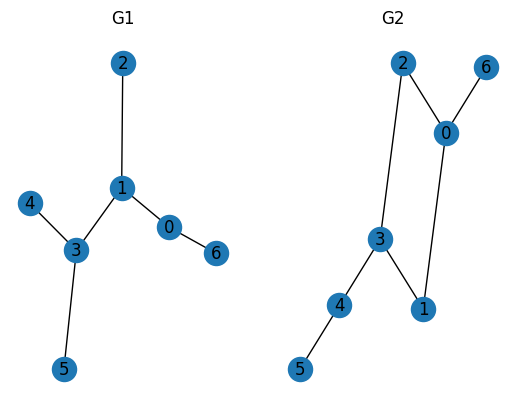

network measures G1 = [1.71, 3.71, 0.78, 0.0, 2.19, -0.45]
network measures G2 = [2.0, 4.57, 0.57, 0.0, 2.19, -0.46]
betti numbers G1: [1 0 0 0 0]
betti numbers G2: [1 1 0 0 0]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A1 = np.array([
#    0 1 2 3 4 5 6
    [0,1,0,0,0,0,1], # 0
    [1,0,1,1,0,0,0], # 1
    [0,1,0,0,0,0,0], # 2
    [0,1,0,0,1,1,0], # 3
    [0,0,0,1,0,0,0], # 4
    [0,0,0,1,0,0,0], # 5
    [1,0,0,0,0,0,0]  # 6
    ]) 
G1 = nx.from_numpy_array(np.array(A1), create_using=nx.Graph)  

A2 = np.array([
#    0 1 2 3 4 5 6
    [0,1,1,0,0,0,1], # 0
    [1,0,0,1,0,0,0], # 1
    [1,0,0,1,0,0,0], # 2
    [0,1,1,0,1,0,0], # 3
    [0,0,0,1,0,1,0], # 4
    [0,0,0,0,1,0,0], # 5
    [1,0,0,0,0,0,0]  # 6
    ]) 
G2 = nx.from_numpy_array(np.array(A2), create_using=nx.Graph)  

plt.subplot(1,2,1)
plt.title("G1")
nx.draw_kamada_kawai(G1,with_labels=True)
plt.subplot(1,2,2)
plt.title("G2")
nx.draw_kamada_kawai(G2,with_labels=True)
plt.show()

results_G1 = network_measures(G1)
results_G2 = network_measures(G2)

print(f"network measures G1 = {[round(result, 2) for result in results_G1]}")
print(f"network measures G2 = {[round(result, 2) for result in results_G2]}")

betti_G1 = betti_numbers(G1)
betti_G2 = betti_numbers(G2)

print("betti numbers G1:", betti_G1)
print("betti numbers G2:", betti_G2)

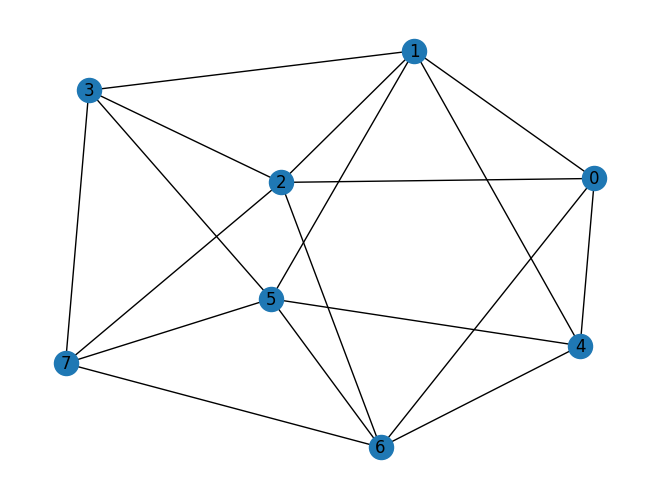

edge simplicial complex
	simplices: 26
	dimension: 1
	betti numbers: [1, 11]
	simplex resume: [8, 18]
clique simplicial complex
	simplices: 38
	dimension: 2
	betti numbers: [1, 0, 1]
	simplex resume: [8, 18, 12]


In [48]:
import networkx as nx
import matplotlib.pyplot as plt

# Monta um grafo que corresponde a a superfície de um cubo tridimensional
G = nx.Graph()

G.add_node(0)
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)
G.add_node(6)
G.add_node(7)

G.add_edge(0,1)
G.add_edge(0,2)
G.add_edge(0,4)
G.add_edge(0,6)
G.add_edge(1,4)
G.add_edge(1,5)
G.add_edge(1,3)
G.add_edge(2,6)
G.add_edge(2,7)
G.add_edge(2,3)
G.add_edge(3,5)
G.add_edge(3,7)
G.add_edge(4,5)
G.add_edge(4,6)
G.add_edge(5,7)
G.add_edge(5,6)
G.add_edge(6,7)
G.add_edge(2,1)

nx.draw_kamada_kawai(G, with_labels=True)
plt.show()

# Converter a rede complexa em um complexo simplicial a partir da lista de arestas
edges_complex = get_simplicial_complex(G, use_cliques=False)

print("edge simplicial complex")
print("\tsimplices:", edges_complex.num_simplices())
print("\tdimension:", edges_complex.dimension())
print("\tbetti numbers:", betti_numbers_of_complex(edges_complex))
print("\tsimplex resume:", simplexes_resume(edges_complex))

# Converter a rede complexa em um complexo simplicial a partir das listas de cliques
complex = get_simplicial_complex(G)
    
print("clique simplicial complex")
print("\tsimplices:", complex.num_simplices())
print("\tdimension:", complex.dimension())
print("\tbetti numbers:", betti_numbers_of_complex(complex))
print("\tsimplex resume:", simplexes_resume(complex))

In [49]:
import networkx as nx

# Gera redes Erdos-Reni, Barabasi-Albert e Watts-Strogatz para comparar propriedades topológicas de alta ordem.
def test_generate_networks(n_nodes, av_degree, n_networks):
    # Parâmetros calculados
    p = av_degree/(n_nodes-1)
    m = int(av_degree/2)
    k = int(av_degree)

    def m_component(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        return G.subgraph(Gcc[0])
    
    def draw_network(G):
        pos = nx.spring_layout(G, seed=42)
        d = dict(G.degree())
        nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)

    for _ in range(0, n_networks):
        # Erdos-Reni
        GER = nx.erdos_renyi_graph(n_nodes, p, seed=None, directed=False)
        # Barabasi-Albert
        GBA = nx.barabasi_albert_graph(n_nodes, m, seed=None)
        # Small-world
        GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    
        plt.figure(figsize=(12, 4))

        plt.subplot(1,3,1)
        plt.title("GER")
        draw_network(GER)
        
        plt.subplot(1,3,2)
        plt.title("GBA")
        draw_network(GBA)
            
        plt.subplot(1,3,3)
        plt.title("GWS")
        draw_network(GWS)
        
        plt.show()
        
        complex_GER = get_simplicial_complex(GER)
        complex_GBA = get_simplicial_complex(GBA)
        complex_GWS = get_simplicial_complex(GWS)

        print("Betti numbers(GER) = ", betti_numbers_of_complex(complex_GER))
        print("Betti numbers(GBA) = ", betti_numbers_of_complex(complex_GBA))
        print("Betti numbers(GWS) = ", betti_numbers_of_complex(complex_GWS))
        
        print ("Simplexes resume(GER):", simplexes_resume(complex_GER))
        print ("Simplexes resume(GBA):", simplexes_resume(complex_GBA))
        print ("Simplexes resume(GWS):", simplexes_resume(complex_GWS))
            
        GER = m_component(GER)
        GBA = m_component(GBA)
        GWS = m_component(GWS)

        er_measures = network_measures(GER)
        ba_measures = network_measures(GBA)
        ws_measures = network_measures(GWS)

        print(f"Network measures(GER) = {[round(result, 2) for result in er_measures]}")
        print(f"Network measures(GBA) = {[round(result, 2) for result in ba_measures]}")
        print(f"Network measures(GWS) = {[round(result, 2) for result in ws_measures]}")

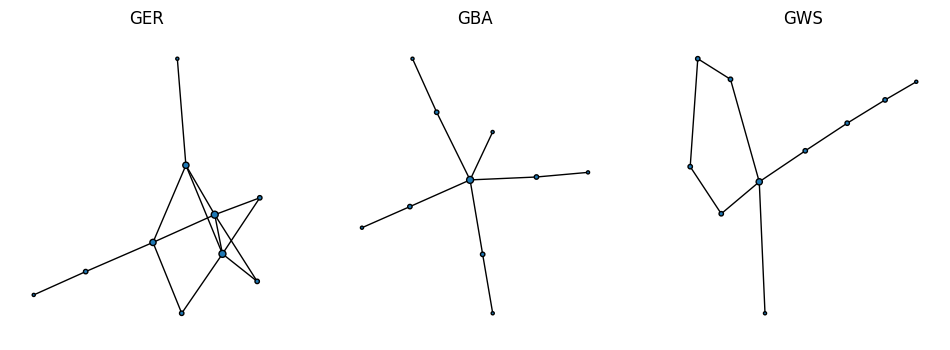

Betti numbers(GER) =  [1, 1, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 1]
Simplexes resume(GER): [10, 14, 4]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10]
Network measures(GER) = [2.8, 10.0, 2.16, 0.32, 2.09, -0.2]
Network measures(GBA) = [1.8, 4.6, 1.36, 0.0, 2.42, -0.26]
Network measures(GWS) = [2.0, 4.6, 0.6, 0.0, 2.76, -0.36]


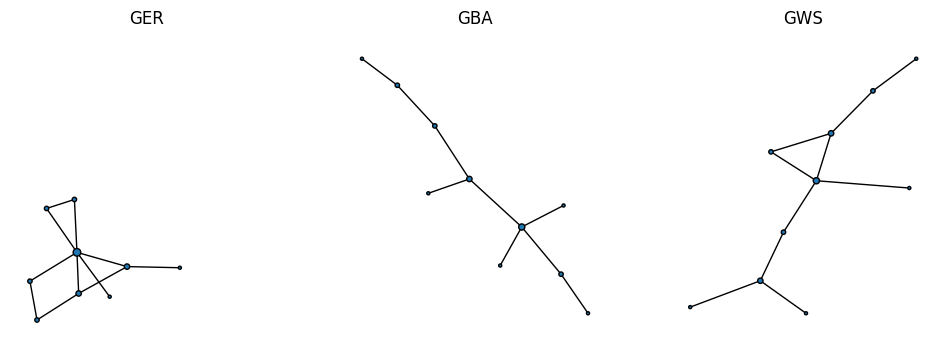

Betti numbers(GER) =  [2, 1, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 0, 0]
Simplexes resume(GER): [10, 11, 2]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10, 1]
Network measures(GER) = [2.44, 8.0, 2.02, 0.31, 1.92, -0.4]
Network measures(GBA) = [1.8, 4.2, 0.96, 0.0, 2.73, -0.36]
Network measures(GWS) = [2.0, 5.0, 1.0, 0.15, 2.76, -0.43]


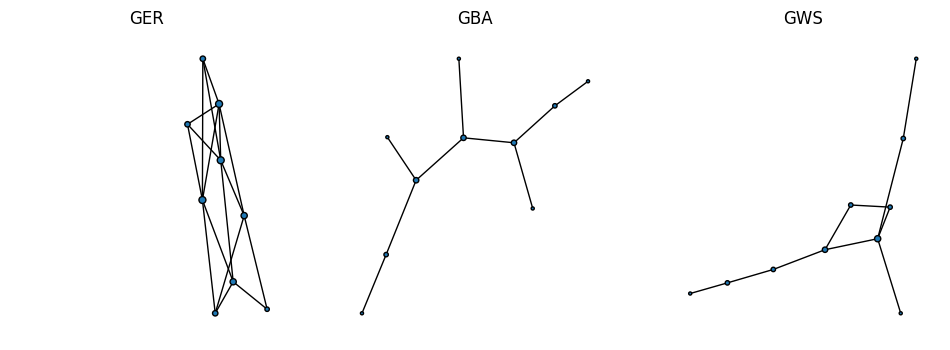

Betti numbers(GER) =  [2, 3, 0]
Betti numbers(GBA) =  [1, 0]
Betti numbers(GWS) =  [1, 1]
Simplexes resume(GER): [10, 17, 6]
Simplexes resume(GBA): [10, 9]
Simplexes resume(GWS): [10, 10]
Network measures(GER) = [3.78, 15.33, 1.06, 0.34, 1.58, -0.32]
Network measures(GBA) = [1.8, 4.0, 0.76, 0.0, 2.78, -0.22]
Network measures(GWS) = [2.0, 4.8, 0.8, 0.0, 2.69, -0.17]


In [50]:
test_generate_networks(10, 3, 3)

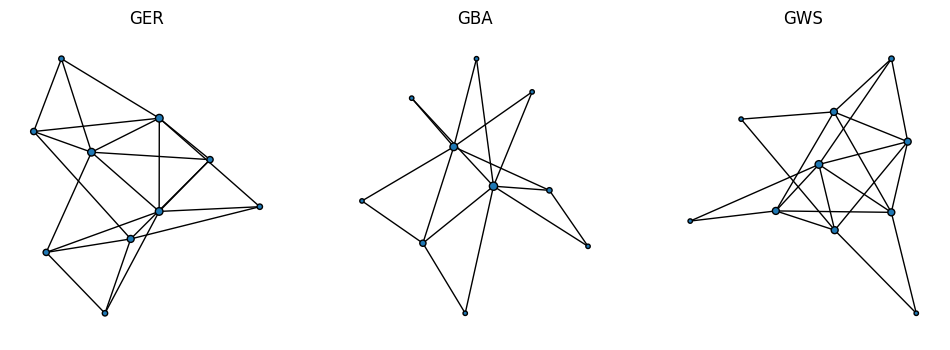

Betti numbers(GER) =  [1, 3, 0, 0]
Betti numbers(GBA) =  [1, 4, 0]
Betti numbers(GWS) =  [1, 2, 0]
Simplexes resume(GER): [10, 22, 12, 2]
Simplexes resume(GBA): [10, 16, 3]
Simplexes resume(GWS): [10, 20, 9]
Network measures(GER) = [4.4, 20.8, 1.44, 0.49, 1.53, -0.37]
Network measures(GBA) = [3.2, 13.4, 3.16, 0.38, 1.67, -0.72]
Network measures(GWS) = [4.0, 18.2, 2.2, 0.39, 1.62, -0.28]


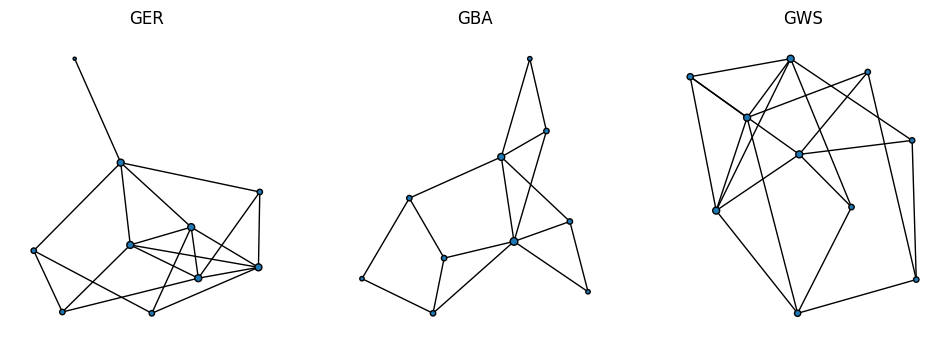

Betti numbers(GER) =  [1, 3, 0, 0]
Betti numbers(GBA) =  [1, 2, 0]
Betti numbers(GWS) =  [1, 6, 0, 0]
Simplexes resume(GER): [10, 19, 8, 1]
Simplexes resume(GBA): [10, 16, 5]
Simplexes resume(GWS): [10, 20, 6, 1]
Network measures(GER) = [3.8, 16.2, 1.76, 0.31, 1.67, -0.11]
Network measures(GBA) = [3.2, 11.8, 1.56, 0.46, 1.82, -0.2]
Network measures(GWS) = [4.0, 16.8, 0.8, 0.21, 1.58, -0.05]


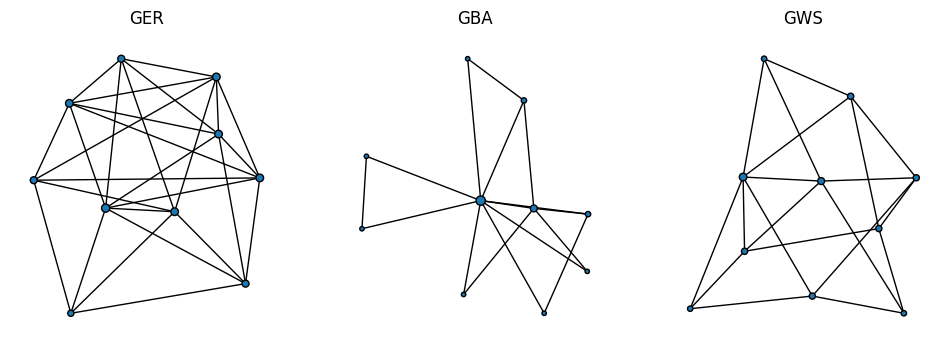

Betti numbers(GER) =  [1, 0, 0, 0]
Betti numbers(GBA) =  [1, 0, 0]
Betti numbers(GWS) =  [1, 5, 0]
Simplexes resume(GER): [10, 28, 26, 7]
Simplexes resume(GBA): [10, 16, 7]
Simplexes resume(GWS): [10, 20, 6]
Network measures(GER) = [5.6, 32.0, 0.64, 0.6, 1.38, -0.14]
Network measures(GBA) = [3.2, 14.8, 4.56, 0.79, 1.64, -0.51]
Network measures(GWS) = [4.0, 16.8, 0.8, 0.3, 1.56, -0.26]


In [51]:
test_generate_networks(10, 5, 3)

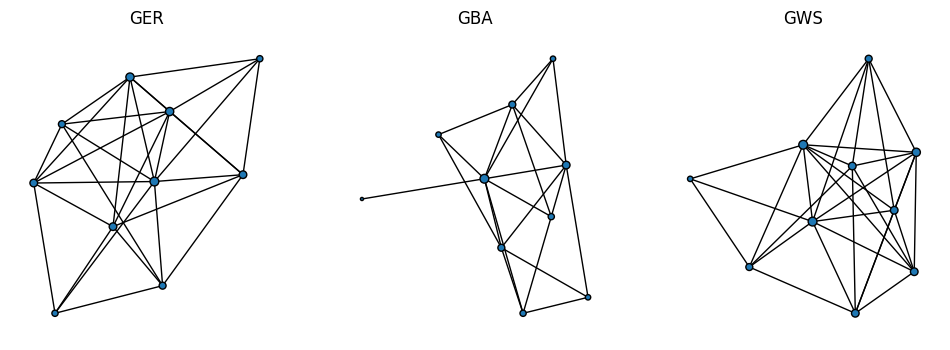

Betti numbers(GER) =  [1, 0, 1, 0, 0]
Betti numbers(GBA) =  [1, 0, 0, 0]
Betti numbers(GWS) =  [1, 0, 1, 0, 0]
Simplexes resume(GER): [10, 29, 31, 12, 2]
Simplexes resume(GBA): [10, 21, 14, 2]
Simplexes resume(GWS): [10, 30, 36, 17, 3]
Network measures(GER) = [5.8, 35.2, 1.56, 0.66, 1.36, -0.23]
Network measures(GBA) = [4.2, 21.0, 3.36, 0.54, 1.56, -0.42]
Network measures(GWS) = [6.0, 38.0, 2.0, 0.72, 1.33, -0.26]


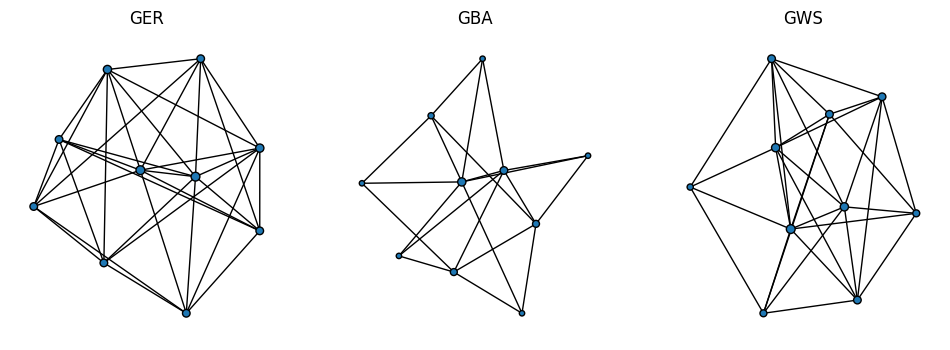

Betti numbers(GER) =  [1, 0, 1, 0, 0]
Betti numbers(GBA) =  [1, 3, 0]
Betti numbers(GWS) =  [1, 0, 1, 0]
Simplexes resume(GER): [10, 33, 43, 21, 3]
Simplexes resume(GBA): [10, 21, 9]
Simplexes resume(GWS): [10, 30, 32, 10]
Network measures(GER) = [6.6, 44.2, 0.64, 0.69, 1.27, -0.13]
Network measures(GBA) = [4.2, 19.6, 1.96, 0.42, 1.53, -0.52]
Network measures(GWS) = [6.0, 37.2, 1.2, 0.62, 1.33, -0.18]


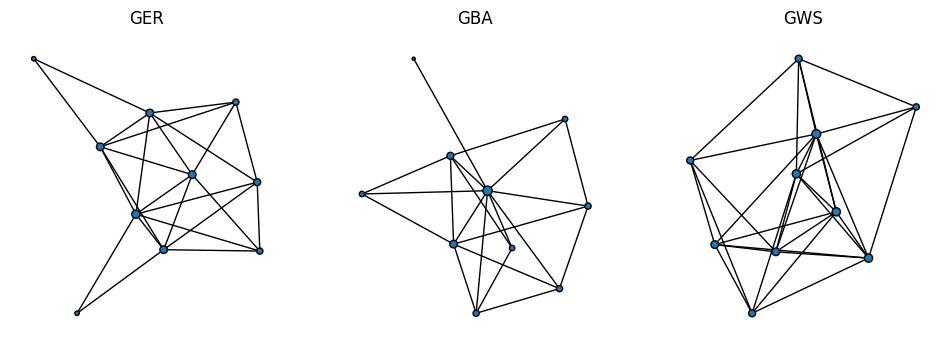

Betti numbers(GER) =  [1, 0, 0, 0]
Betti numbers(GBA) =  [1, 0, 0, 0]
Betti numbers(GWS) =  [1, 0, 0, 0, 0]
Simplexes resume(GER): [10, 24, 20, 5]
Simplexes resume(GBA): [10, 21, 15, 3]
Simplexes resume(GWS): [10, 30, 34, 15, 2]
Network measures(GER) = [4.8, 25.8, 2.76, 0.67, 1.53, -0.28]
Network measures(GBA) = [4.2, 21.8, 4.16, 0.59, 1.53, -0.45]
Network measures(GWS) = [6.0, 37.4, 1.4, 0.66, 1.33, -0.14]


In [52]:
test_generate_networks(10, 6, 3)

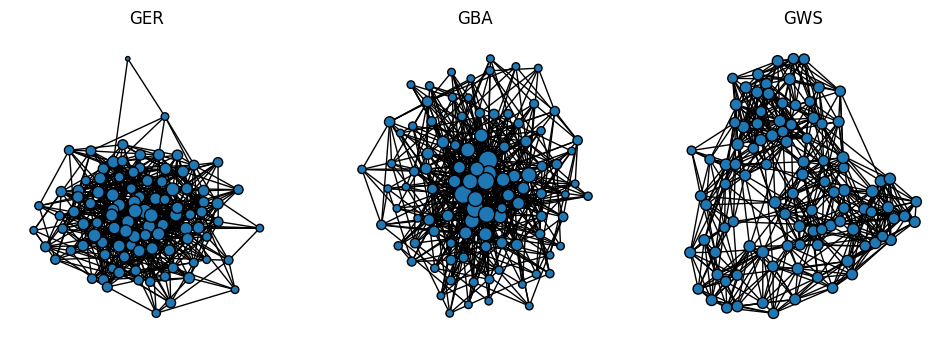

Betti numbers(GER) =  [1, 223, 1, 0]
Betti numbers(GBA) =  [1, 130, 6, 0, 0, 0]
Betti numbers(GWS) =  [1, 55, 7, 0, 0, 0, 0]
Simplexes resume(GER): [100, 574, 269, 16]
Simplexes resume(GBA): [100, 564, 465, 151, 30, 3]
Simplexes resume(GWS): [100, 600, 1020, 869, 369, 71, 4]
Network measures(GER) = [11.48, 141.84, 10.05, 0.12, 2.12, 0.03]
Network measures(GBA) = [11.28, 170.92, 43.68, 0.18, 2.13, -0.07]
Network measures(GWS) = [12.0, 145.3, 1.3, 0.46, 2.43, 0.03]


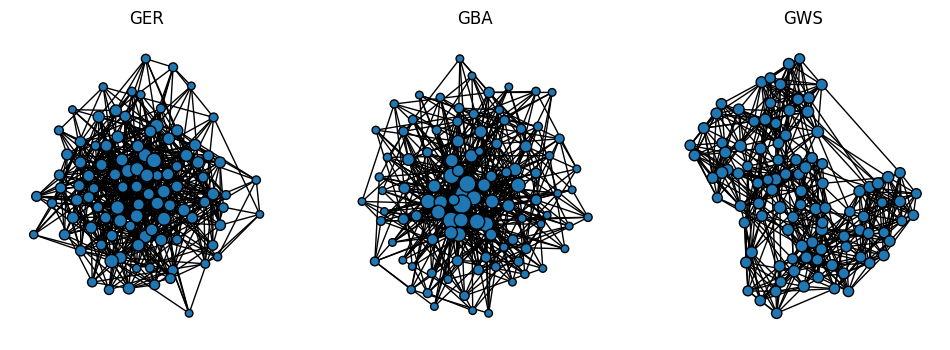

Betti numbers(GER) =  [1, 248, 0, 0]
Betti numbers(GBA) =  [1, 119, 7, 0, 0]
Betti numbers(GWS) =  [1, 63, 3, 1, 0, 0, 0]
Simplexes resume(GER): [100, 592, 257, 12]
Simplexes resume(GBA): [100, 564, 458, 110, 5]
Simplexes resume(GWS): [100, 600, 1022, 895, 375, 65, 3]
Network measures(GER) = [11.84, 151.5, 11.31, 0.11, 2.09, -0.04]
Network measures(GBA) = [11.28, 171.94, 44.7, 0.2, 2.11, -0.1]
Network measures(GWS) = [12.0, 145.26, 1.26, 0.47, 2.4, 0.01]


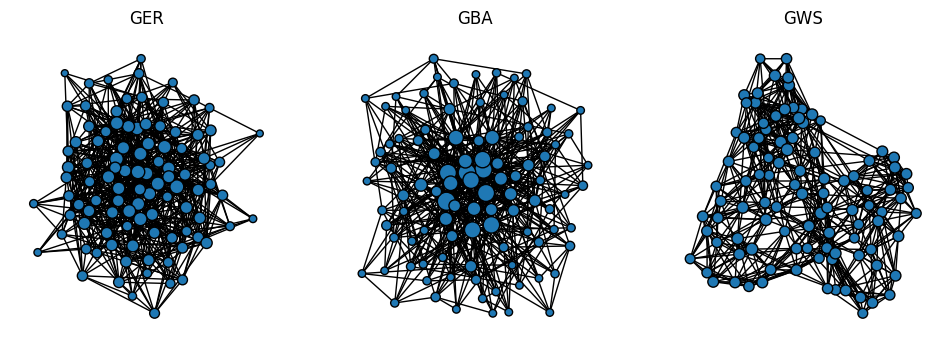

Betti numbers(GER) =  [1, 221, 0, 0]
Betti numbers(GBA) =  [1, 101, 11, 0, 0]
Betti numbers(GWS) =  [1, 57, 2, 0, 0, 0, 0]
Simplexes resume(GER): [100, 618, 313, 15]
Simplexes resume(GBA): [100, 564, 495, 137, 17]
Simplexes resume(GWS): [100, 600, 1062, 973, 444, 93, 6]
Network measures(GER) = [12.36, 163.3, 10.53, 0.13, 2.05, -0.12]
Network measures(GBA) = [11.28, 177.54, 50.3, 0.22, 2.11, -0.14]
Network measures(GWS) = [12.0, 145.36, 1.36, 0.49, 2.42, -0.01]


In [53]:
test_generate_networks(100, 12, 3)

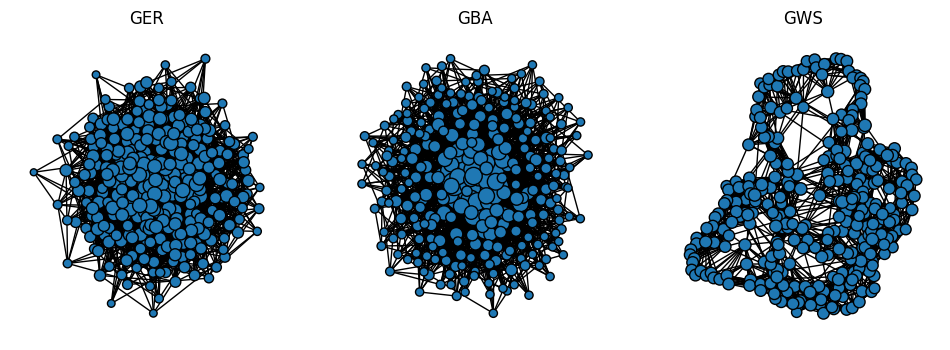

Betti numbers(GER) =  [1, 1342, 0, 0]
Betti numbers(GBA) =  [1, 738, 18, 0, 0, 0]
Betti numbers(GWS) =  [1, 102, 0, 0, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2110, 475, 3]
Simplexes resume(GBA): [297, 2030, 1291, 330, 58, 5]
Simplexes resume(GWS): [297, 2079, 5321, 7525, 6047, 2767, 674, 69]
Network measures(GER) = [14.21, 214.61, 12.72, 0.05, 2.44, 0.01]
Network measures(GBA) = [13.67, 292.75, 105.88, 0.11, 2.4, -0.06]
Network measures(GWS) = [14.0, 196.82, 0.82, 0.59, 3.34, -0.02]


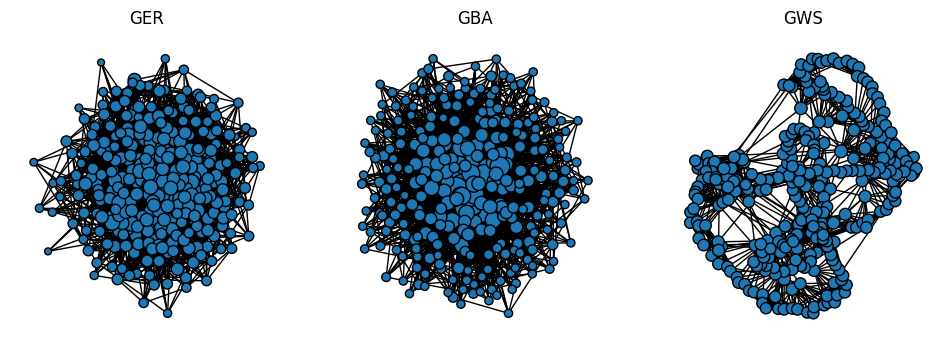

Betti numbers(GER) =  [1, 1297, 0, 0]
Betti numbers(GBA) =  [1, 691, 28, 0, 0, 0]
Betti numbers(GWS) =  [1, 69, 0, 0, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2024, 434, 3]
Simplexes resume(GBA): [297, 2030, 1325, 283, 30, 1]
Simplexes resume(GWS): [297, 2079, 5590, 8288, 7052, 3417, 862, 85]
Network measures(GER) = [13.63, 199.01, 13.24, 0.05, 2.46, -0.0]
Network measures(GBA) = [13.67, 294.56, 107.69, 0.11, 2.4, -0.07]
Network measures(GWS) = [14.0, 196.44, 0.44, 0.62, 3.6, -0.03]


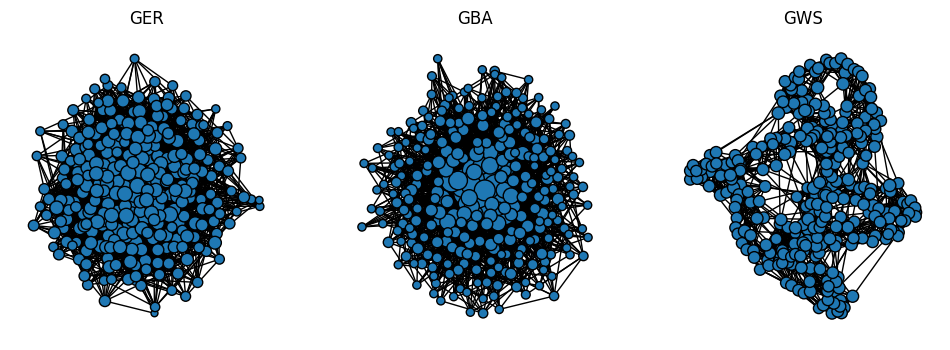

Betti numbers(GER) =  [1, 1381, 0, 0]
Betti numbers(GBA) =  [1, 664, 26, 0, 0, 0]
Betti numbers(GWS) =  [1, 112, 0, 1, 0, 0, 0, 0]
Simplexes resume(GER): [297, 2180, 506, 3]
Simplexes resume(GBA): [297, 2030, 1368, 299, 28, 1]
Simplexes resume(GWS): [297, 2079, 5241, 7302, 5746, 2550, 590, 55]
Network measures(GER) = [14.68, 228.55, 13.04, 0.05, 2.41, 0.02]
Network measures(GBA) = [13.67, 305.9, 119.03, 0.12, 2.39, -0.09]
Network measures(GWS) = [14.0, 196.75, 0.75, 0.58, 3.3, -0.04]


In [54]:
test_generate_networks(297, 14, 3)

network_measures= (14.464646464646465, 376.7811447811448, 167.5551474339353, 0.29236329783219006, 2.455318955318955, -0.16319921031570375)
simplices: 8779
dimension: 7
betti_numbers= [1, 139, 121, 4, 0, 0, 0, 0]
simplex resume= [297, 2148, 3241, 2010, 801, 240, 40, 2]


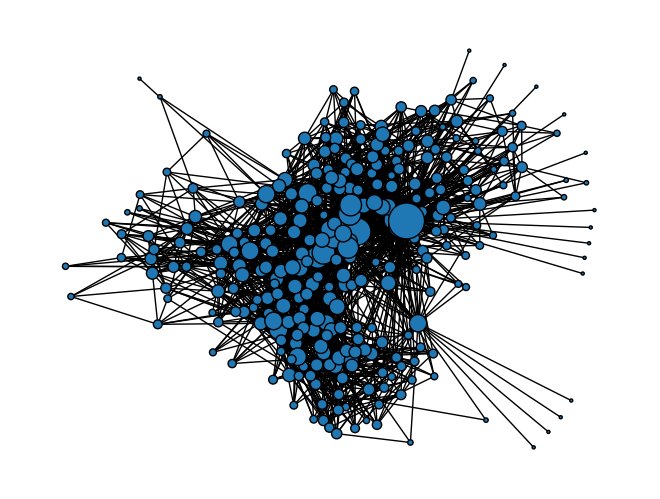

In [55]:
filename = "data/out.dimacs10-celegansneural"

G = OpenNetwork(filename, digraph=False)

pos = nx.spring_layout(G, seed=42)
d = dict(G.degree())
nx.draw(G, pos, node_size=[v * 5 for v in d.values()], edgecolors='black', with_labels=False)

complex = get_simplicial_complex(G)

print("network_measures=", network_measures(G))
print("simplices:", complex.num_simplices())
print("dimension:", complex.dimension())
print("betti_numbers=", betti_numbers_of_complex(complex))
print("simplex resume=", simplexes_resume(complex))

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import umap

def classifier(y, X, X_test, cl=['ER','WS','BA'], colors=['red', 'blue', 'green']):
    y = np.array(y)

    # Padroniza os recursos removendo a média e dimensionando para a variância da unidade.
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_test = np.array(X_test)
    X_test = X_test.reshape(1,len(X_test)) 
    X_test = scaler.transform(X_test)

    # Reduz para 2 dimensões com PCA Principal Component Analysis
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=0))

    # Reduz para 2 dimensões com Linear Discriminant Analysis
    lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

    # Reduz para 2 dimensões com Uniform Manifold Approximation and Projection
    uma = umap.UMAP()

    dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("UMAP", uma)]

    n_neighbors=10
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'euclidean')
 
    plt.figure(figsize=(12, 4))
    # Plot each method's projection
    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.subplot(1,3,i+1)

        # Fit the method's model
        model.fit(X, y)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X)
        
        # Embed the test case in 2 dimensions using the fitted model
        X_test_embedded = model.transform(X_test.reshape(1, -1))
    
        # Make predictions using KNN
        knn.fit(X_embedded, y)
                
        # Find the k nearest neighbors to the center point
        _, indices = knn.kneighbors(X_test_embedded, n_neighbors=k)
        neighbors = X_embedded[indices][0]
        
        # Calculate the radius of the circle
        radius = np.max(np.linalg.norm(neighbors - X_test_embedded, axis=1))
        
        # Draw a circle around the center point with the calculated radius
        circle = plt.Circle([X_test_embedded[:,0], X_test_embedded[:,1]], radius, color='black', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)
        
        y_pred = knn.predict(X_test_embedded)
            
        print('Class:', cl[int(np.mean(y_pred))])
        
        for j in range(len(cl)):
            plt.scatter(
                X_embedded[y == j, 0],
                X_embedded[y == j, 1],
                c=colors[j],
                s=30,
                label=cl[j],
            )
        plt.scatter(
            X_test_embedded[:, 0],
            X_test_embedded[:, 1],
            c='black',
            s=100,
            marker="X",
            label="Test Case",
        )
        plt.legend()
        plt.title(name)
        plt.axis('equal')
        
    plt.show()

number of nodes=297 average degree=14.464646464646465
Class: BA
Class: BA
Class: BA


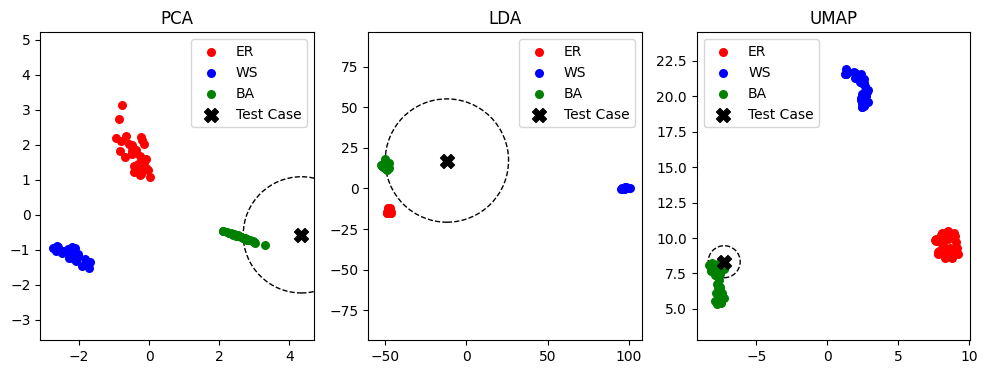

Class: BA
Class: WS
Class: BA


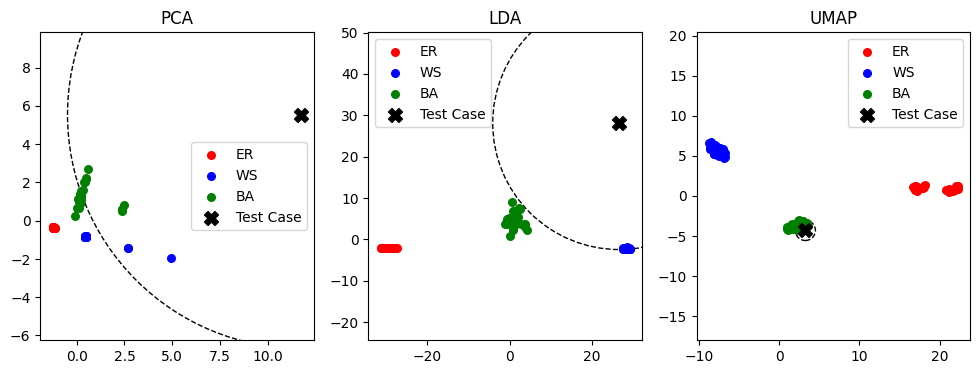

In [69]:
import networkx as nx

# Parâmetros de simulação
n_nets = 30  # Quantidade de redes
n_nodes = len(G)  # Quantidade de vértices
av_degree = momment_of_degree_distribution(G, 1) # Grau médio

print(f"number of nodes={n_nodes} average degree={av_degree}")

# Vetores para impressão de resultados
X_measures = []
X_betti_num = []
y = []

#ER networks
p = av_degree/(n_nodes-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(n_nodes, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GER)
    X_betti_num.append(x)
    y.append(0)

#WS networks
k = int(av_degree)
p = 0.05 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(n_nodes, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GWS)
    X_betti_num.append(x)
    y.append(1)

# BA networks
m = int(av_degree/2)
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(n_nodes, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k1,k2,variance,av_cl,l,r = network_measures(GBA)
    x = [k1,k2,variance,av_cl,l,r]
    X_measures.append(x)
    x = betti_numbers(GBA)
    X_betti_num.append(x)
    y.append(2)
    

k1,k2,variance,av_cl,l,r = network_measures(G)
X_test = [k1, k2, variance, av_cl, l, r]
classifier(y, X_measures, X_test)

X_test = betti_numbers(G)
classifier(y, X_betti_num, X_test)
